In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 

import ClassCOMPAS     as CC ###


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# nModels=17
# BPSnameslist = list(string.ascii_uppercase)[0:nModels]

# physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
#                            r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
#                            r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic}' +'\n' + r'\textbf{CE}',\
#                           r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
#                           r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
#                           r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' , r'$\rm{f}_{\rm{WR}} = 0.1$', r'$\rm{f}_{\rm{WR}} = 5$']

# alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}





def plot_kdes_single(axe=None, axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, \
                               whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/'):
    
  
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    # constants
    Zsolar=0.0142
    lw = 2
    nSFRD = 28 # number of SFRD models 
    
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 

    DCOname_dict = {'BHNS':'BHNS', 'BBH':'BHBH', 'BNS':'NSNS'}
    DCOname = DCOname_dict[DCOtype]
#     xvarHeaders = ['Mass1', 'Mass2', 'tc',\
#                'log10(tc)', 'TotMass', 'ChirpMass', 'q', 'metallicitySystems', 'log10metallicitySystems', 'tdelay',\
#                'log10(tdelay)']
    xvar_dict = {'Mtot':4,'Mass1':0, 'Mass2':1, 'q':6, 'ChirpMass':5, 'logZ':8, 'Z':7, 'tc':2, 'log10(tc)':3, 'tdelay':9, 'log10(tdelay)':10 }


    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        color_m = colorDirDict[BPSmodelName]
        
        if axe_ind!=None:
            axe = axe[ind_m,axe_ind]
        else:
            axe=axe
        
        
        
        if ind_m==0:
            print('now at m=', BPSmodelName)

        

        

        # data for KDE / PDF:
        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
        print(path)
        fdata = h5.File(path)

            

        if xparam in ['Mass1', 'Mass2', 'q', 'ChirpMass', 'Mtot']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            del xvar1
            del xvar2
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='Mass1':
                xvar = M1
            elif xparam=='Mass2':
                xvar = M2 
            elif xparam =='q':
                xvar = M1/M2
            elif xparam=='ChirpMass':
                xvar = chirpmass(M1,M2)

            del M1
            del M2


        elif xparam=='logZ':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            del ZZ 

        elif xparam=='Z':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = ((ZZ))
            del ZZ


        elif xparam=='tc':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = tc / 1000. # in Gyr. 
            del tc

        elif xparam=='tdelay':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
            xvar = (tc/1000) + (tform / 1000) # in Gyr 
            del tc 
            del tform
        else:
            print('KeyError')





        ymax=0
        ii=0
        print(MSSFRmodelNames)
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            # highlight the SFRD if they are one of the following 3
            if mssfr in ['000', '231', '312']:
                MSSFRalpha=1
                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]                    
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
            else:
                MSSFRalpha=0.5
                MSSFRlinestyle = '-'
                MSSFRzorder=51   






            # make the KDE, by calculating KDE values for the following x points 
            xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

#             # set bandwidth (dimensionless) based on the no of samples in the data. 
            lenXvar = len(xvar)
    
            bw = 0.4 # TEMP
#             if lenXvar<=100000:
#                 bw=0.1
#             elif lenXvar>2*10**6:
#                 bw = 0.04
#             elif (lenXvar<=2*10**6) & (lenXvar>10**6):
#                 bw = 0.04
#             elif (lenXvar<=10**6) & (lenXvar>5*10**5):
#                 bw = 0.05 
#             elif (lenXvar<=5*10**5) & (lenXvar>10**5):
#                 bw = 0.06
#             else:
#                 print('error!! bw not defined')

            # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
            if xparam=='logZ':
                bw = 0.1
            if (mssfr=='000')&(axe_ind==0):
                print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)

                
                
            KDE = MirroredKDE(xvar, lower_bound=min(xvar), upper_bound=max(xvarrange), weights=w, bw_method=bw) 
                
        
#             KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
            yy_boot = KDE(xx_boot)
            del KDE 

            axe.plot(xx_boot, yy_boot, alpha=MSSFRalpha, color='gray', zorder=MSSFRzorder, label=None,\
                     linewidth=lw, linestyle=MSSFRlinestyle ) 
            
#             axe.plot(xx_boot, yy_boot*xx_boot, alpha=MSSFRalpha, color=color_m, zorder=MSSFRzorder, label=None,\
#                      linewidth=lw, linestyle=MSSFRlinestyle ) 

            ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
            ylim_max =ymax*1.05 
            
            
            
            
            delta_x = (xx_boot[1:]-xx_boot[0:-1])[0]
            print(np.sum(yy_boot*delta_x))




            


                
        fdata.close()
        axe.set_ylim(0.001, ylim_max)

                
    
        del xvar
        del w

        
        
        


    
    return 





In [3]:

def make_up_axis(axe=None, axe_ind=0, BPSmodelNames=['A'], xlim=[1,3.], ylim=[0.1,10], nameX='xname', nameY='yname', logY=False, logX=False):
    for ind_bps, bps_name in enumerate(BPSnameslist):
        
        axe = ax[ind_bps, axe_ind]
#         if ind_bps 

                
        if logY==True:
            axe.set_yscale('log')
        if logX==True:
            axe.set_xscale('log')
        if xlim:
            axe.set_xlim(xlim[0], xlim[1])
        if ylim:
            axe.set_ylim(ylim[0], ylim[1])
        
        if bps_name != BPSmodelNames[-1]:
            
            axe.set_xticklabels( () )
            axe.set_xticks([])

            axe.set_yticks([])
            axe.set_yticklabels( () )
            
        
        
        
        
        if  (nameX==None):

            axe.set_xticklabels( () )
            axe.set_xticks([])

        elif (nameY==None):
            axe.set_yticks([])
            axe.set_yticklabels( () )   
            
            
#         if (nameX!=None) & (nameY==None):
#             layoutAxesNoYlabel()

    return 





def make_up_axis_single_ax(axe=None,  xlim=[1,3.], ylim=[0.1,10], logY=False, logX=False):

#         if ind_bps 


    if logY==True:
        axe.set_yscale('log')
    if logX==True:
        axe.set_xscale('log')
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

#     if bps_name != BPSmodelNames[-1]:

#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#         axe.set_yticks([])
#         axe.set_yticklabels( () )




# #     else:
#     if  (nameX==None):
#         axe.set_xticklabels( () )
#         axe.set_xticks([])

#     elif (nameY==None):
#         axe.set_yticks([])
#         axe.set_yticklabels( () )   




    return 



In [4]:





# def mass_distribution_plot(axe=None, axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, labelname='xlabel name', \
#                               whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/', quantiles=False,\
#                   pathQuantiles='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_4_5_6/'):
    

    
    
    
    
#     if quantiles==True:
#         plot_percentiles(axe, axe_ind, xparam, BPSmodelNames, MSSFRmodelNames, DCOtype,  \
#                               whichWeight, path_dir, pathQuantiles)
#     else:# quantiles==True:
#         plot_kdes(axe, axe_ind, xparam, BPSmodelNames, MSSFRmodelNames, DCOtype, xvarrange, \
#                               whichWeight, path_dir)


        

    
    
#     return






In [5]:
# def layoutAxesNoXlabel(ax, nameX='', nameY='', \
#                labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True, rotation=0):
#     """
#     Tiny code to do the layout for axes in matplotlib
#     """
#     tickLengthMajor = 10
#     tickLengthMinor = 5
#     tickWidthMajor  = 1.5
#     tickWidthMinor  = 1.5
    
#     #rc('axes', linewidth=2)
#     #label1 always refers to first axis not the twin 
#     if not second:
#         for tick in ax.xaxis.get_major_ticks():
#             tick.label1.set_fontsize(fontsize)
#             #tick.label1.set_fontweight('bold')
#         for tick in ax.yaxis.get_major_ticks():
#             tick.label1.set_fontsize(fontsize)
#             #tick.label1.set_fontweight('bold')
#     if second:
#         for tick in ax.xaxis.get_major_ticks():
#             tick.label2.set_fontsize(fontsize)
#             #tick.label1.set_fontweight('bold')
#         for tick in ax.yaxis.get_major_ticks():
#             tick.label2.set_fontsize(fontsize)
#             #tick.label1.set_fontweight('bold')
#     for axis in ['top','bottom','left','right']:
#         ax.spines[axis].set_linewidth(1.2)
#     ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
#     ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
#     # ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
#     ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad, rotation=rotation, va="center")#, fontweight='bold')    




#     if setMinor==True:
#         # add minor ticks:
#         ax.xaxis.set_minor_locator(AutoMinorLocator())
#         ax.yaxis.set_minor_locator(AutoMinorLocator())

#     return ax

now at m= G
/Volumes/Andromeda/DATA/AllDCO_bugfix/alpha0_1/COMPASCompactOutput_BBH_G.h5
['112']
0.9997528274305674


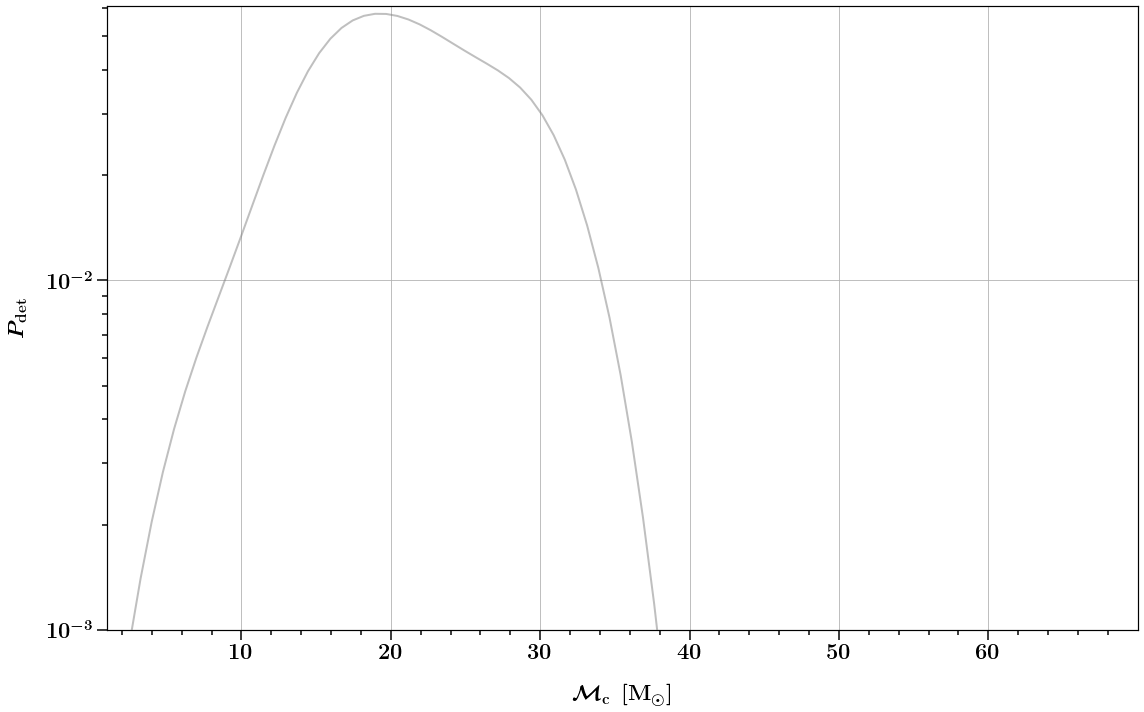

In [6]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'

ncols, nrows= 1,1
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})


TYPE = 'BBH'
DCOtype='BBH'

# GLOBAL SETTINGS 
whichWeight='det' # which weighting we want (intrinisic or detecter)
# path to the file with the distribution quantiles / percentiles: 
# pathQuantiles='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_4_5_6/'

fs_t = 22


# FIRST COLUMN WITH CHIRP MASS ###
xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{\rm{c}}$ $ \,  [\rm{M}_{\odot}]$' 
# plot percentiles:
plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=['G'], MSSFRmodelNames=['112'], DCOtype=DCOtype, xvarrange=[1, 75], \
                              whichWeight=whichWeight, path_dir=path_dir)
xlim=[1.01,69.99]
# make_up_axis_single_ax(axe=ax, BPSmodelNames=['A'], xlim=xlim, ylim=None , nameX=xlabelname, nameY='Probability', logY=False, logX=False)
layoutAxes(ax=ax, nameX=xlabelname, nameY=r'${P}_{\rm{det}} $', labelpad=20, fontsize=fs_t)
make_up_axis_single_ax(axe=ax,  xlim=xlim, ylim=None, logY=True, logX=False)


# # top label
# ylim=None
# ax2x = ax.twiny()
# make_up_axis_single_ax(ax2x, 'A', BPSnameslist, xlim, ylim, nameY=None, logY=False, logX=False)
# layoutAxes(ax=ax2x, nameX=xlabelname, nameY=None, second=True, labelpad=20, fontsize=fs_t)






# # add y labels on the left. 
# for ind_bps, bps_name in enumerate(BPSnameslist):
#     nameY = r'\textbf{%s}'%bps_name
#     layoutAxesNoXlabel(ax=ax[ind_bps,axe_ind], nameX=None, nameY=nameY, labelpad=20, rotation=0)





# # add y labels on the right. 
# for ind_bps, bps_name in enumerate(BPSnameslist):
#     nameY = alphabetPhysicalNameDictWithEnter[bps_name]
#     ax2y = ax[ind_bps,axe_ind].twinx()
    
#     make_up_axis_single_ax(ax2y, 'A', BPSnameslist, xlim, ylim, nameY=None, logY=False, logX=False)
#     layoutAxesNoXlabel(ax=ax2y, nameX=None, nameY=nameY, labelpad=25, rotation=90, fontsize=17)


##  SAVE FIG  ###
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0)  
plt.savefig('./KDEplot_chirpmass' + whichWeight +'_'  + DCOtype+ '.png', transparent=False)
plt.show()
plt.close()






In [ ]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'

ncols, nrows= 1,1
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})


TYPE = 'BBH'
DCOtype='BBH'

# GLOBAL SETTINGS 
whichWeight='det' # which weighting we want (intrinisic or detecter)
# path to the file with the distribution quantiles / percentiles: 
# pathQuantiles='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_4_5_6/'

fs_t = 22


# FIRST COLUMN WITH CHIRP MASS ###
xparam, axe_ind, xlabelname ='ChirpMass', None,  r' $\mathcal{M}_{\rm{c}}$ $ \,  [\rm{M}_{\odot}]$' 
# plot percentiles:
# plot_kdes_single(axe=ax, axe_ind=axe_ind, xparam=xparam, BPSmodelNames=['A'], MSSFRmodelNames=['112'], DCOtype=DCOtype, xvarrange=[1, 75], \
#                               whichWeight=whichWeight, path_dir=path_dir)
xlim=[1.01,69.99]
make_up_axis(axe=ax, axe_ind=axe_ind, BPSmodelNames=['A'], xlim=xlim, ylim=None , nameX=xlabelname, nameY=None, logY=False, logX=False)
layoutAxesNoYlabel(ax=ax[nModels-1,axe_ind], nameX=xlabelname, nameY=None, labelpad=20, fontsize=fs_t)
# top label
ylim=None
ax2x = ax[0,axe_ind].twiny()
make_up_axis_single_ax(ax2x, 'A', BPSnameslist, xlim, ylim, nameY=None, logY=False, logX=False)
layoutAxesNoYlabel(ax=ax2x, nameX=xlabelname, nameY=None, second=True, labelpad=20, fontsize=fs_t)






# # add y labels on the left. 
# for ind_bps, bps_name in enumerate(BPSnameslist):
#     nameY = r'\textbf{%s}'%bps_name
#     layoutAxesNoXlabel(ax=ax[ind_bps,axe_ind], nameX=None, nameY=nameY, labelpad=20, rotation=0)





# # add y labels on the right. 
# for ind_bps, bps_name in enumerate(BPSnameslist):
#     nameY = alphabetPhysicalNameDictWithEnter[bps_name]
#     ax2y = ax[ind_bps,axe_ind].twinx()
    
#     make_up_axis_single_ax(ax2y, 'A', BPSnameslist, xlim, ylim, nameY=None, logY=False, logX=False)
#     layoutAxesNoXlabel(ax=ax2y, nameX=None, nameY=nameY, labelpad=25, rotation=90, fontsize=17)


##  SAVE FIG  ###
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0)  
plt.savefig('./KDEplot_chirpmass' + whichWeight +'_'  + DCOtype+ '.png', transparent=False)
plt.show()
plt.close()




